# 3.8.2 SHAP Model Visualizations
#### for both monotonic and non-monotonic models

## 1) Load Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

Change some pandas settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

Set some path constants

In [3]:
saved_models_path = os.path.join(os.getcwd(), 'models')
datasets_path = os.path.join(os.getcwd(), 'data')

## 2) Load Data

### 2.1) Load One-hot encoded version

In [37]:
train_df = pd.read_csv(os.path.join(datasets_path, 'new.train.1hot.df.csv'))
test_df = pd.read_csv(os.path.join(datasets_path, 'new.test.1hot.df.csv'))

### 2.2) Some Minor Data Prep

Drop useless columns

In [38]:
train_df = train_df.drop(columns=["Unnamed: 0"])
test_df = test_df.drop(columns=["Unnamed: 0"])

Reorder default to first

In [39]:
train_df = train_df[['default', 'loan_amnt', 'term_36MO', 'term_60MO', 'int_rate', 'installment', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'annual_inc', 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED', 'verification_status_VERIFIED', 'purpose_CREDIT_CARD', 'purpose_DEBT_CONSOLIDATION', 'purpose_HOME_IMPROVEMENT', 'purpose_MAJOR_PURCHASE', 'purpose_OTHERS', 'purpose_SMALL_BUSINESS', 'dti', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status_F', 'initial_list_status_W', 'compensation_of_employees', 'gross_operating_surplus', 'per_capita_real_gdp_by_state', 'quantity_indexes_for_real_gdp_by_state', 'real_gdp_by_state', 'subsidies', 'taxes_on_production_and_imports', 'regions_MIDWEST', 'regions_NORTHEAST', 'regions_SOUTH', 'regions_WEST', 'month']]
test_df = test_df[['default', 'loan_amnt', 'term_36MO', 'term_60MO', 'int_rate', 'installment', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'annual_inc', 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED', 'verification_status_VERIFIED', 'purpose_CREDIT_CARD', 'purpose_DEBT_CONSOLIDATION', 'purpose_HOME_IMPROVEMENT', 'purpose_MAJOR_PURCHASE', 'purpose_OTHERS', 'purpose_SMALL_BUSINESS', 'dti', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status_F', 'initial_list_status_W', 'compensation_of_employees', 'gross_operating_surplus', 'per_capita_real_gdp_by_state', 'quantity_indexes_for_real_gdp_by_state', 'real_gdp_by_state', 'subsidies', 'taxes_on_production_and_imports', 'regions_MIDWEST', 'regions_NORTHEAST', 'regions_SOUTH', 'regions_WEST', 'month']]

See summary stats to make sure data has no issues

In [40]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,204640.0,13522.286699,8128.199436,500.00,7200.00,12000.00,18200.00,35000.00
term_36MO,204640.0,0.777370,0.416013,0.00,1.00,1.00,1.00,1.00
term_60MO,204640.0,0.222630,0.416013,0.00,0.00,0.00,0.00,1.00
int_rate,204640.0,13.780552,4.387821,5.32,10.74,13.61,16.55,28.99
installment,204640.0,416.810278,244.639684,15.69,238.06,364.38,546.21,1424.57
grade_A,204640.0,0.165618,0.371738,0.00,0.00,0.00,0.00,1.00
grade_B,204640.0,0.297601,0.457204,0.00,0.00,0.00,1.00,1.00
grade_C,204640.0,0.258556,0.437842,0.00,0.00,0.00,1.00,1.00
grade_D,204640.0,0.161249,0.367761,0.00,0.00,0.00,0.00,1.00
grade_E,204640.0,0.077302,0.267070,0.00,0.00,0.00,0.00,1.00


Check for missing values

In [41]:
test_df.isna().any()

default                                   False
loan_amnt                                 False
term_36MO                                 False
term_60MO                                 False
int_rate                                  False
installment                               False
grade_A                                   False
grade_B                                   False
grade_C                                   False
grade_D                                   False
grade_E                                   False
grade_F                                   False
grade_G                                   False
home_ownership_MORTGAGE                   False
home_ownership_OWN                        False
home_ownership_RENT                       False
annual_inc                                False
verification_status_NOT_VERIFIED          False
verification_status_SOURCE_VERIFIED       False
verification_status_VERIFIED              False
purpose_CREDIT_CARD                     

### 2.3) Convert Datasets to Numpy Arrays
#### (they are all numeric so this should work fine)

In [42]:
train = train_df
test = test_df
train.default = train.default.astype(int)
test.default = test.default.astype(int)

In [43]:
train = train.as_matrix()
test = test.as_matrix()

/home/sri/anaconda3/envs/pt1/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/sri/anaconda3/envs/pt1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Make sure they are all the right shape

In [ ]:
train.shape

In [ ]:
test.shape

### 2.4) Generate Y/X Sets for all versions

In [ ]:
x_train = train[:,1:44]
y_train = train[:,0:1]
x_test = test[:,1:44]
y_test = test[:,0:1]

### 2.5) Create DMatrixes

In [51]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

## 3) Load Models

### 3.1) Monotonic 

First tried loading model...

In [25]:
mono_mdl = xgb.Booster()
mono_mdl.load_model(os.path.join(saved_models_path, 'new.xgb.mono.opt.costopt.mdl'))

In [26]:
mono_mdl.feature_names = train_df.columns[1:44]

...but model wouldn't load correctly because of discrepancies between R and Python saved model formats so I retrained it with exactly the same parameters and data:

In [57]:
mono_params = dict(
    booster = "gbtree",
    max_depth = 5,
    min_child_weight = 2,
    eta = 0.170257653004955,
    gamma = 0.393479593470693,
    subsample = 0.9, 
    colsample_bytree = 0.8, 
    objective = "binary:logistic",
    eval_metric= "aucpr",
    monotone_constraints = "(1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1)"
)
mono_mdl2 = xgb.train(params = mono_params, num_boost_round = 153, dtrain = dtrain)

### 3.2) Non-Monotonic 

First tried loading model...

In [27]:
nonmono_mdl = xgb.Booster()
nonmono_mdl.load_model(os.path.join(saved_models_path, 'new.xgb.opt.costopt.mdl'))

In [28]:
nonmono_mdl.feature_names = train_df.columns[1:44]

...but model wouldn't load correctly because of discrepancies between R and Python saved model formats so I retrained it with exactly the same parameters and data:

In [58]:
nonmono_params = dict(
    booster = "gbtree",
    max_depth = 5,
    min_child_weight = 2,
    eta = 0.0691802625378494,
    gamma = 0.193399890288106,
    subsample = 0.9, 
    colsample_bytree = 0.8, 
    objective = "binary:logistic",
    eval_metric= "aucpr"
)
nonmono_mdl2 = xgb.train(params = nonmono_params, num_boost_round = 256, dtrain = dtrain)

## 4) SHAP Inference

### 4.1) Monotonic

#### 4.1.1) Summary Plot

In [60]:
shap_mono = mono_mdl2.predict(dtest, pred_contribs=True)

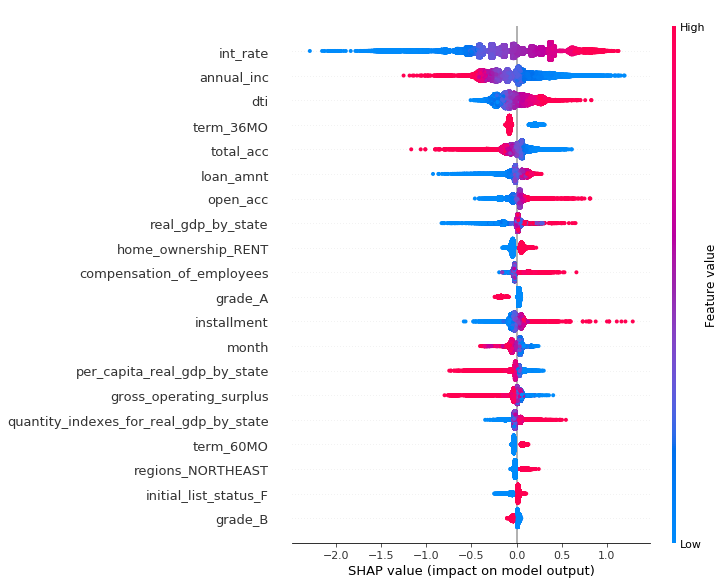

In [63]:
shap.summary_plot(shap_mono[:, :-1], test_df[mono_mdl2.feature_names])

#### 4.1.2) Dependence Plots for 3 top variables

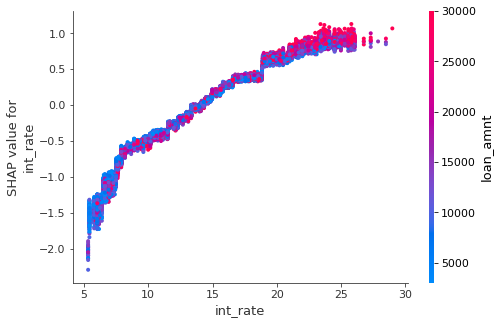

In [70]:
shap.dependence_plot("int_rate", shap_mono[:, :-1], test_df[mono_mdl2.feature_names])

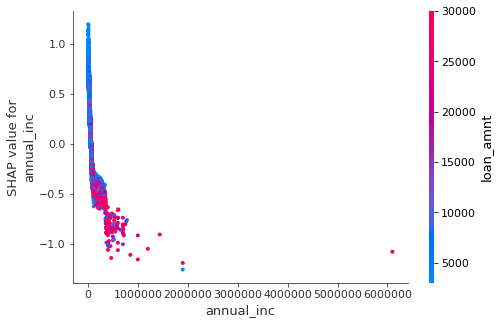

In [71]:
shap.dependence_plot("annual_inc", shap_mono[:, :-1], test_df[mono_mdl2.feature_names])

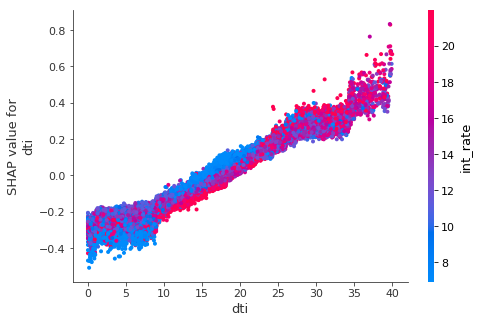

In [72]:
shap.dependence_plot("dti", shap_mono[:, :-1], test_df[mono_mdl2.feature_names])

#### 4.1.3) SHAP Interaction Values

In [76]:
mono_interaction = shap.TreeExplainer(mono_mdl2).shap_interaction_values(test_df[mono_mdl2.feature_names])

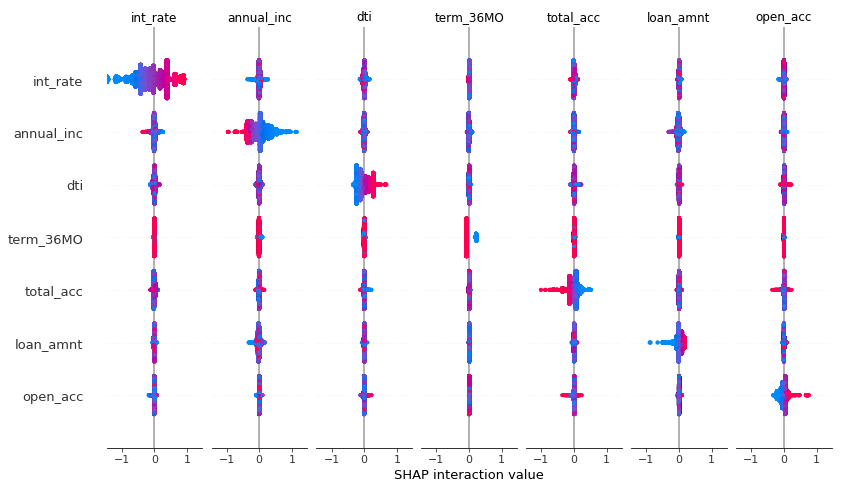

In [81]:
shap.summary_plot(mono_interaction, test_df[mono_mdl2.feature_names])

### 4.2) Non-Monotonic

#### 4.2.1) Summary Plot

In [64]:
shap_nonmono = nonmono_mdl2.predict(dtest, pred_contribs=True)

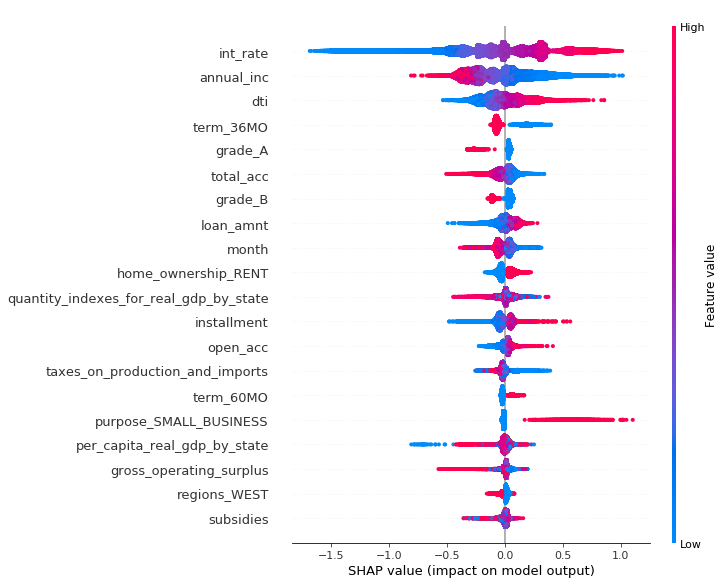

In [65]:
shap.summary_plot(shap_nonmono[:, :-1], test_df[nonmono_mdl2.feature_names])

#### 4.2.2) Dependence Plots for 3 top variables

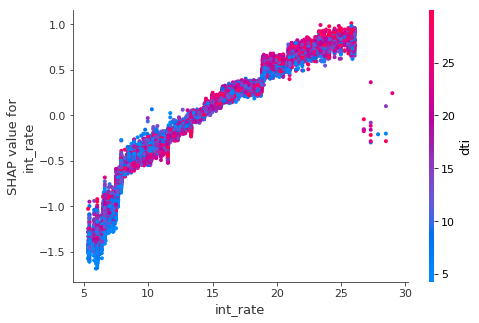

In [73]:
shap.dependence_plot("int_rate", shap_nonmono[:, :-1], test_df[nonmono_mdl2.feature_names])

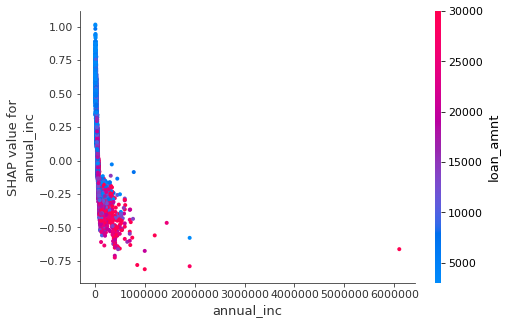

In [74]:
shap.dependence_plot("annual_inc", shap_nonmono[:, :-1], test_df[nonmono_mdl2.feature_names])

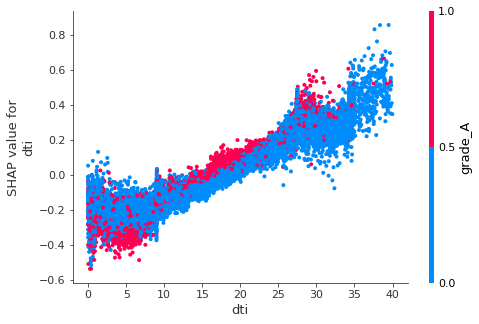

In [75]:
shap.dependence_plot("dti", shap_nonmono[:, :-1], test_df[nonmono_mdl2.feature_names])

#### 4.2.3) SHAP Interaction Values

In [77]:
nonmono_interaction = shap.TreeExplainer(nonmono_mdl2).shap_interaction_values(test_df[nonmono_mdl2.feature_names])

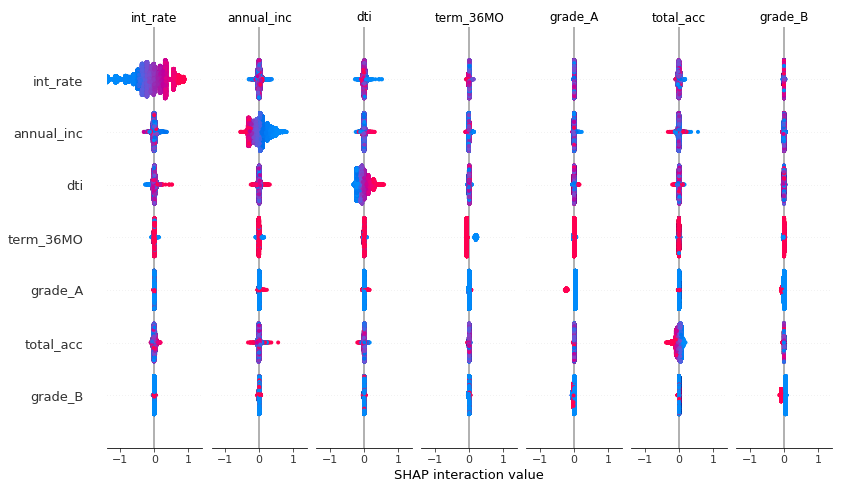

In [79]:
shap.summary_plot(nonmono_interaction, test_df[nonmono_mdl2.feature_names])